# Random Forest for Grocery Store

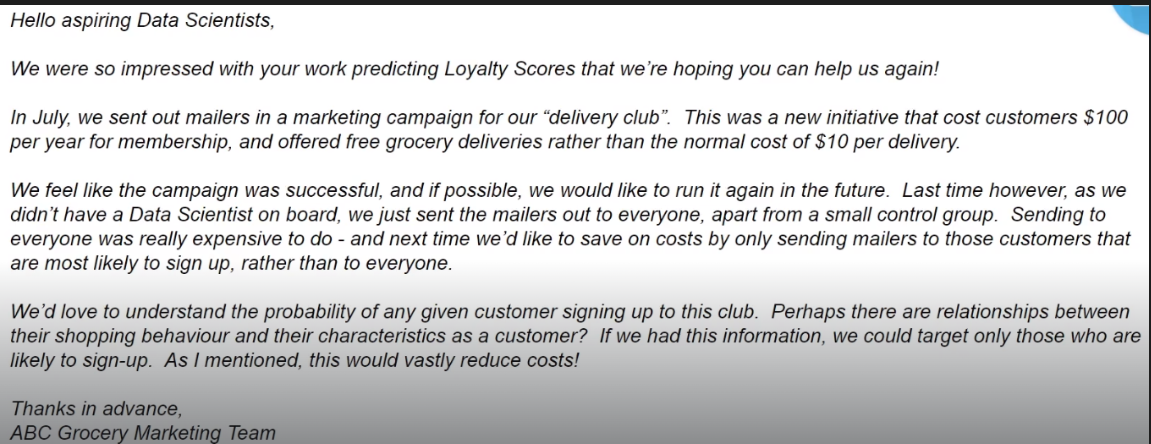

In [16]:
# import required packages
import pandas as pd
import pickle
# import required packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.inspection import permutation_importance

In [3]:
# import, learning to import using pickle files
data_for_model = pickle.load(open('Saved_files/abc_classification_modelling.p','rb'))

# we dont really need the id for the model
data_for_model.drop('customer_id', axis=1, inplace=True)
print(data_for_model.shape)
data_for_model.head()


(860, 9)


,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [4]:
# shuffle data just in case it either came in in some order
# or we accidentally ordered it which will cause model to error
data_for_model = shuffle(data_for_model,random_state=42)
print(data_for_model.shape)
data_for_model.head()

(860, 9)


,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
714,0,1.64,M,0.58,27.81,6,3,3,9.270000
605,0,0.88,M,0.63,26.62,9,3,2,8.873333
120,0,0.56,M,0.62,886.78,154,18,4,49.265556
208,0,0.11,M,0.58,1256.19,168,34,5,36.946765
380,0,1.32,M,0.36,739.67,110,21,3,35.222381


In [5]:
# class balance
data_for_model['signup_flag'].value_counts(normalize=True)

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

In [6]:
######################################################
# deal with missing values
######################################################
data_for_model.isna().sum()
# small number of columns with missing values, lets not impute and just drop 
# but noted 

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [7]:
# "any" meaning drop the whole row if any one cell is empty
data_for_model.dropna(how="any", inplace=True)
print(data_for_model.shape)
data_for_model.head()

(847, 9)


,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
714,0,1.64,M,0.58,27.81,6,3,3,9.270000
605,0,0.88,M,0.63,26.62,9,3,2,8.873333
120,0,0.56,M,0.62,886.78,154,18,4,49.265556
208,0,0.11,M,0.58,1256.19,168,34,5,36.946765
380,0,1.32,M,0.36,739.67,110,21,3,35.222381


In [8]:
######################################################
# deal with outliers
######################################################
outlier_investigation = data_for_model.describe()
print(outlier_investigation)
# some outliers in distance_from_store, total_sales, total_items
# all others did not spark any issues

       signup_flag  distance_from_store  credit_score  total_sales  \
count   847.000000           847.000000    847.000000   847.000000   
mean      0.304604             2.614545      0.597521   968.166411   
std       0.460512            14.397590      0.102264  1073.647531   
min       0.000000             0.000000      0.260000     2.090000   
25%       0.000000             0.730000      0.530000   383.940000   
50%       0.000000             1.640000      0.590000   691.640000   
75%       1.000000             2.920000      0.670000  1121.530000   
max       1.000000           400.970000      0.880000  7372.060000   

       total_items  transaction_count  product_area_count  \
count   847.000000         847.000000          847.000000   
mean    143.877214          22.214876            4.177096   
std     125.342694          11.721699            0.920887   
min       1.000000           1.000000            1.000000   
25%      77.000000          16.000000            4.000000   
50%

In [9]:
######################################################
# split input variables and output variables
######################################################
# we dont want the output in the input dataframe
X = data_for_model.drop(['signup_flag'], axis=1)
Y = data_for_model['signup_flag']

In [10]:
######################################################
# split out training and test sets
######################################################
# Regression model 
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.2,
                                                    random_state=42,
                                                    stratify=Y)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(677, 8)
(170, 8)
(677,)
(170,)


In [11]:
######################################################
# deal with categorical variables
######################################################
# gender
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")# array is easier to use and viduallize 
# avoid dummy variable trap

In [12]:
# fit and transform on the training and only the transform on the test
# we do this because we want the encoding rules to be learned from the 
# training data and then applied to the new data 
X_train_encoded_vars_array = one_hot_encoder.fit_transform(x_train[categorical_vars])
X_test_encoded_vars_array = one_hot_encoder.transform(x_test[categorical_vars])
print(X_train_encoded_vars_array.shape)
print(X_test_encoded_vars_array.shape)

(677, 1)
(170, 1)


c:\Users\eacalder\.conda\envs\DSInfinity\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [14]:
X_train_encoded_vars_array = pd.DataFrame(X_train_encoded_vars_array,
                               columns=encoder_feature_names)
x_train = pd.concat([x_train.reset_index(drop=True),
                   X_train_encoded_vars_array.reset_index(drop=True)], 
                   axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_train.drop(categorical_vars, axis=1,inplace=True)
print(x_train.shape)
print(x_train.head())

(677, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 1.22          0.60       636.51          123   
1                 0.86          0.56      1141.28          112   
2                 1.23          0.79      1207.42          210   
3                 1.04          0.40        78.18           11   
4                 0.07          0.62       740.51           94   

   transaction_count  product_area_count  average_basket_value  gender_M  
0                 22                   5             28.932273       0.0  
1                 21                   5             54.346667       1.0  
2                 26                   4             46.439231       1.0  
3                  3                   2             26.060000       1.0  
4                 24                   5             30.854583       1.0  


the removal of the gender F column that usually does the dummy variable trap does not affect decision trees but adding it wouldnt have done it better either or

In [15]:
X_test_encoded_vars_array = pd.DataFrame(X_test_encoded_vars_array,
                               columns=encoder_feature_names)
x_test = pd.concat([x_test.reset_index(drop=True),
                   X_test_encoded_vars_array.reset_index(drop=True)], axis=1)
# reset index to ensure no rows are not aligned
# drop the original input 2 and 3
x_test.drop(categorical_vars, axis=1,inplace=True)
print(x_test.shape)
print(x_test.head())

(170, 8)
   distance_from_store  credit_score  total_sales  total_items  \
0                 1.92          0.64      1283.76          191   
1                 5.38          0.64      5180.71          662   
2                 3.18          0.67      2482.50          288   
3                 1.59          0.50       319.37           85   
4                 2.73          0.36      1146.93          211   

   transaction_count  product_area_count  average_basket_value  gender_M  
0                 30                   5             42.792000       0.0  
1                 56                   5             92.512679       0.0  
2                 30                   5             82.750000       0.0  
3                 17                   5             18.786471       1.0  
4                 24                   3             47.788750       0.0  


In [17]:
######################################################
# model train
######################################################
clf = RandomForestClassifier(random_state=42, 
                             n_estimators=500, 
                             max_features=5)
# cranks up the 100 default 
# later looking at the grid search functionality 
# to have scikit learn test for us
clf.fit(x_train,y_train)

RandomForestClassifier(max_features=5, n_estimators=500, random_state=42)

In [18]:
######################################################
# model assessment
######################################################
# Predict on the Test Set 
y_pred_class = clf.predict(x_test)
y_pred_prob = clf.predict_proba(x_test)[:,1] # probabilities
# 50% threshold 
# prob gives another view

In [19]:
# confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred_class)
print(conf_matrix)

[[112   6]
 [  5  47]]


C:\Users\eacalder\AppData\Local\Temp\1/ipykernel_15256/2987787315.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


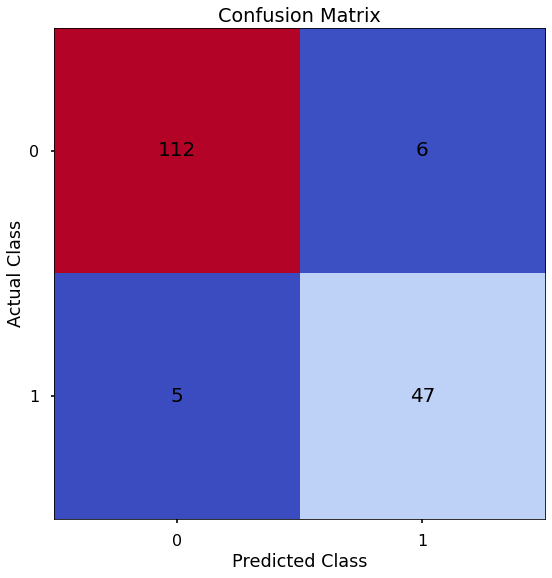

In [20]:
plt.style.use("seaborn-poster")
plt.matshow(conf_matrix, cmap = "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion Matrix")
plt.ylabel("Actual Class") 
plt.xlabel("Predicted Class")
# dont hve to go through just understand and look up if need to
for (i, j), corr_value in np.ndenumerate (conf_matrix):
    plt.text(j, i, corr_value, ha = "center", va = "center", fontsize = 20)
plt.show() 

results are almost exactly the same as prior

In [21]:
accuracy_score(y_test,y_pred_class)

0.9352941176470588

In [22]:
precision_score(y_test,y_pred_class)

0.8867924528301887

In [23]:
recall_score(y_test,y_pred_class)

0.9038461538461539

In [24]:
f1_score(y_test,y_pred_class)

0.8952380952380953

lets understand which of our inputs are important 
feature importance! 

In [25]:
feature_importance = pd.DataFrame(clf.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance],
                                       axis = 1)
feature_importance_summary.columns = ['input_variable', 'feature_importance']
feature_importance_summary.sort_values(by='feature_importance',inplace=True)
feature_importance_summary.head()

,input_variable,feature_importance
1,gender,0.024698
3,total_sales,0.039331
7,average_basket_value,0.051438
4,total_items,0.057100
6,product_area_count,0.094937


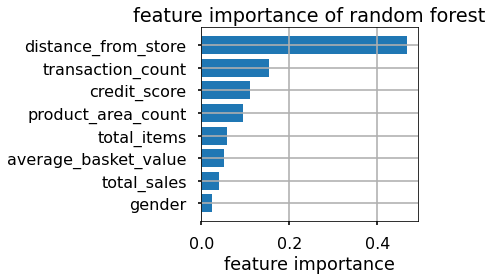

In [26]:
plt.barh(feature_importance_summary['input_variable'],feature_importance_summary['feature_importance'])
plt.title("feature importance of random forest")
plt.xlabel("feature importance")
# plt.ylabel("y label")
plt.tight_layout()
plt.grid(True)
plt.show()

we have the feature importance, another way of calculating this out is by 

permutation importance - more advised to use, slightly superiors  

In [27]:
result = permutation_importance(clf, 
                                x_test, 
                                y_test, 
                                n_repeats=10,
                                random_state=42)
print(result)

{'importances_mean': array([ 0.29764706, -0.00529412, -0.00058824, -0.00529412,  0.02941176,
        0.10941176,  0.00235294,  0.02294118]), 'importances_std': array([0.02685344, 0.00411765, 0.00850402, 0.00411765, 0.01366935,
       0.01294118, 0.00470588, 0.0080869 ]), 'importances': array([[ 0.33529412,  0.32352941,  0.31176471,  0.33529412,  0.26470588,
         0.3       ,  0.28823529,  0.25882353,  0.28823529,  0.27058824],
       [-0.00588235, -0.00588235, -0.01176471, -0.00588235,  0.        ,
         0.        , -0.00588235, -0.00588235,  0.        , -0.01176471],
       [-0.00588235, -0.01176471,  0.        ,  0.00588235,  0.        ,
        -0.01176471,  0.        ,  0.01764706,  0.00588235, -0.00588235],
       [ 0.        , -0.00588235,  0.        , -0.01176471,  0.        ,
        -0.00588235, -0.00588235, -0.00588235, -0.01176471, -0.00588235],
       [ 0.03529412,  0.00588235,  0.02941176,  0.03529412,  0.01176471,
         0.04705882,  0.02352941,  0.04705882,  0.04

In [28]:
permutation_importance = pd.DataFrame(result['importances_mean'])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance],
                                       axis = 1)
permutation_importance_summary.columns = ['input_variable', 'feature_importance']
permutation_importance_summary.sort_values(by='feature_importance',inplace=True)
permutation_importance_summary.head()

,input_variable,feature_importance
1,gender,-0.005294
3,total_sales,-0.005294
2,credit_score,-0.000588
6,product_area_count,0.002353
7,average_basket_value,0.022941


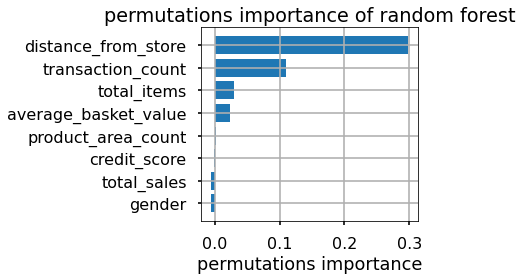

In [29]:
plt.barh(permutation_importance_summary['input_variable'],permutation_importance_summary['feature_importance'])
plt.title("permutations importance of random forest")
plt.xlabel("permutations importance")
# plt.ylabel("y label")
plt.tight_layout()
plt.grid(True)
plt.show()

NOTE:
consistent to most part
there are negative (total sales and gender)
- predictions on the shuffled data happened to be more accurate than on the real data 
- this happens when your input variable doesnt matter 
- random chance 